In [1]:
import numpy as np
import pandas as pd
#import training setvalid_newfeature
#Train_df = pd.read_csv('/project/tffm-master/csvs/train_sample0.1_4.csv')
Train_df = pd.read_csv('/project/tffm-master/csvs/train_sample0.1_4.csv')
#import validation set
Valid_df = pd.read_csv('/project/Data/valid_newfeature.csv')

In [28]:
1+1

2

In [3]:
# columns of without click
cols=list(Train_df.columns)[1:]

In [4]:
Train_df.shape

(244712, 127)

In [5]:
Train_df['slotheight']=Train_df['slotheight']/10
Train_df['slotwidth']=Train_df['slotwidth']/100
Train_df['slotprice']=Train_df['slotprice']/100

Valid_df['slotheight']=Valid_df['slotheight']/10
Valid_df['slotwidth']=Valid_df['slotwidth']/100
Valid_df['slotprice']=Valid_df['slotprice']/100

In [6]:
#train = Train_df
y_tr = Train_df['click']
X_tr = Train_df[cols]
y_te = Valid_df['click']
X_te = Valid_df[cols]

In [7]:
X_te=X_te.values
X_tr=X_tr.values
y_te=y_te.values
y_tr=y_tr.values

In [8]:
import scipy.sparse as sp
# only CSR format supported
X_tr_sparse = sp.csr_matrix(X_tr)
X_te_sparse = sp.csr_matrix(X_te)

In [9]:
! pip install tqdm

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
#23:33
#train Factorised Machine model
from tffm import TFFMClassifier
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


model = TFFMClassifier(
    order=3, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=30, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='sparse',
    seed=42
)

model.fit(X_tr_sparse, y_tr, show_progress=True)

    


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


100%|██████████| 30/30 [04:15<00:00,  8.51s/epoch]


In [11]:
valid_predictions = model.predict_proba(X_te_sparse)
valid_predictions_class = model.predict(X_te_sparse)

acc = accuracy_score(y_te, valid_predictions_class)
print('model: {}'.format(model.__str__()))
print("the accuracy is: {0:6f}".format(acc))
print ("the AUC for FM is: {0:6f}".format(roc_auc_score(y_te, valid_predictions[:,1])))
print("==================================")


model: TFFMClassifier()
the accuracy is: 0.999115
the AUC for FM is: 0.875950


In [12]:
valid_result = pd.DataFrame(columns=['click', 'click_pred_per', 'click_pred_class'])  
valid_result['click']= Valid_df['click'].copy()
valid_result['click_pred_per'] = valid_predictions[:,1]
valid_result['click_pred_class'] = valid_predictions_class
valid_result.head()

,click,click_pred_per,click_pred_class
0,0,0.000307,0
1,0,0.000190,0
2,0,0.000142,0
3,0,0.000331,0
4,0,0.001594,0


In [13]:
def recalibrate(p,w):
    q = p/(p+(1-p)/w)
    return q

In [14]:
valid_result['click_pred_per']=recalibrate(valid_result['click_pred_per'],0.1)
valid_result.head(20)

,click,click_pred_per,click_pred_class
0,0,0.000031,0
1,0,0.000019,0
2,0,0.000014,0
3,0,0.000033,0
4,0,0.000160,0
5,0,0.000231,0
6,0,0.000268,0
7,0,0.000685,0
8,0,0.000282,0
9,0,0.000011,0


In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_test = valid_result['click']
y_pred_class = valid_result['click_pred_class']

print(confusion_matrix(y_test, y_pred_class))

confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print ("TP:", TP)
print ("TN:", TN)
print ("FP:", FP)
print ("FN:", FN)

#准确率、识别率（Classification Accuracy）：分类器正确分类的比例
#print ((TP+TN) / float(TP+TN+FN+FP))
print ("Accuracy: %.6f%%" % (accuracy_score(y_test, y_pred_class)* 100.0) )

#灵敏性（Sensitivity），也称为真正例识别率、召回率（Recall）：正确识别的正例数据在实际正例数据中的百分比
#print (TP / float(TP+FN))
#recall = metrics.recall_score(y_test, y_pred_class)
print ("Recall: %.6f%%" % (recall_score(y_test, y_pred_class)* 100.0))

#特效性（Specificity），也称为真负例率：正确识别的负例数据在实际负例数据中的百分比
print ("Specificity: %.6f%%" % (TN / float(TN+FP)* 100.0))

#假阳率（False Positive Rate）：实际值是负例数据，预测错误的百分比
#print (FP / float(TN+FP))
specificity = TN / float(TN+FP)
print ("False Positive Rate: %.6f%%" %((1 - specificity)*100.0))

#精度（Precision）：看做精确性的度量，即标记为正类的数据实际为正例的百分比
#print (TP / float(TP+FP))
precision = precision_score(y_test, y_pred_class)
print ("Precision: %.6f%%" %(precision*100.0))

#F1（平衡F分数）：精确率和召回率的调和平均数
#print (TP / float(TP+FP))
f1 = f1_score(y_test, y_pred_class)
print ("F1 score: %.6f%%" %(f1*100.0))

[[303697     26]
 [   179     23]]
TP: 23
TN: 303697
FP: 26
FN: 179
Accuracy: 99.932549%
Recall: 11.386139%
Specificity: 99.991440%
False Positive Rate: 0.008560%
Precision: 46.938776%
F1 score: 18.326693%


In [43]:
def agree_to_flag(click_pred_per):
    if click_pred_per >=0.5:
        return 1
    else:
        return 0
valid_result['click_pred_class'] = valid_result['click_pred_per'].map(agree_to_flag)



In [44]:
valid_result.head()

,click,click_pred_per,click_pred_class
0,0,0.000031,0
1,0,0.000019,0
2,0,0.000014,0
3,0,0.000033,0
4,0,0.000160,0


In [45]:


# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt


# IMPORTANT: first argument is true values, second argument is predicted probabilities
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def plot_ROC_curve(data, prediction):
    """
    Function to plot the ROC curve with AUC.
    """

    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(data, prediction)
    roc_auc = roc_auc_score(data, prediction)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    #plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC curve for CTR')
    plt.grid(True)
    plt.legend(loc="lower right")
    
    return





the AUC for FM is: 0.875950


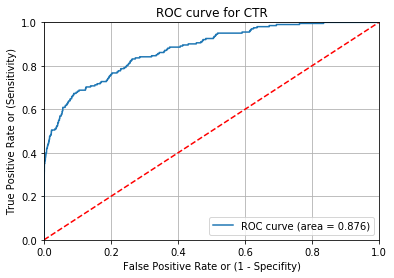

In [46]:
plot_ROC_curve(valid_result['click'], valid_result['click_pred_per'])
#xgboost的auc
print ("the AUC for FM is: {0:6f}".format(roc_auc_score(valid_result['click'], valid_result['click_pred_per'])))

the AUC for FM is: 0.860693


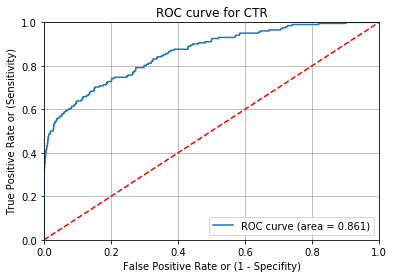

In [20]:
plot_ROC_curve(valid_result['click'], valid_result['click_pred_per'])
#xgboost的auc
print ("the AUC for FM is: {0:6f}".format(roc_auc_score(valid_result['click'], valid_result['click_pred_per'])))

In [21]:
#Find Base Bid
#! pip install mpld3

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import mpld3
import numpy as np

In [17]:
df_valid = pd.read_csv("/project/Data/validation.csv")

In [18]:
# parameters
total_budget = 6250000
payprice = df_valid['payprice'].as_matrix()
Train_df_qr = df_valid.copy()
avgCTR = 1793/2430981 #train set
#tuning...

In [19]:
def generate_bidprice(base_bid, test_predictions):
    avgCTR = 1793/2430981#train set
    bidprices = base_bid*test_predictions/avgCTR
    return bidprices

In [20]:
def Prob3(Train_df,payprice,base_bid,test_predictions):
    Train_Const_summ = pd.DataFrame({'Clicks':'', 'Spend':'', 'CTR':'', 'CPM':'', 'eCPC':''}, index=[0])
    
    #if count_break = 5 break
    count_break = 0
    
    current_budget = total_budget
    Train_df['win'] = 0 #initialize win label
    bidprices = generate_bidprice(base_bid, test_predictions)
    #start biding...
    for i in Train_df.index:
        current_bidprice = bidprices[i]
        #consider budget
        if current_budget <= current_bidprice:              
            #count lack budget times
            count_break = count_break + 1
#             print('lack of budget!',"current_budget:",current_budget,";current_bidprice:",current_bidprice,';count_break:',count_break)
            if count_break > 5:
                break  
            #reset bidprice
            current_bidprice = current_budget
        else:
            count_break = 0
            

        #Winning criterion:
        current_payprice = payprice[i]
        if current_bidprice > current_payprice:
            Train_df.at[i, 'win'] = int(1)
            current_budget = current_budget - current_payprice
        else:
            Train_df.at[i, 'win'] = int(0)

    #biding end        
    
    Train_df_new = Train_df[Train_df['win']!=0]
    #wintimes,_ = Train_df_new.shape
    #print('wintimes:',wintimes)
    #print('current_budget',current_budget)

    
#     #commented in for
#     Clk = Train_df_new['click'].sum()
#     Imp = Train_df_new['click'].count()
#     CTR = Clk/Imp
#     Spd = total_budget - current_budget
#     CPM = 1000*Spd/Imp
#     eCPC = Spd/Clk
    
#     Train_Const_summ.loc[0,'Clicks']=Clk
#     Train_Const_summ.loc[0,'Spend']=Spd
#     Train_Const_summ.loc[0,'CTR']=CTR
#     Train_Const_summ.loc[0,'CPM']=CPM
#     Train_Const_summ.loc[0,'eCPC']=eCPC

#     print(Train_Const_summ)
    
        
    return Train_df,current_budget

In [21]:
def calculate_click(base_bid,Train_df,payprice,test_predictions):
#     print('base_bid:',base_bid)
    result_df,current_budget = Prob3(Train_df,payprice,base_bid,test_predictions)
#     print('current_budget:',current_budget)
    Train_df_new = result_df[result_df['win']!=0]
    wintimes,_ = Train_df_new.shape
#     print('wintimes:',wintimes)
#     print('----------------')
    Clk = Train_df_new['click'].sum()    
    return Clk

In [25]:
#test range
base_bids = np.arange(160,180,1)#区间可以适当左右调整一下，但大概就是这个范围
count = 0
maxClks = []

In [26]:
count = count + 1
print(str(count)+" valid result is being test...")
test_predictions=valid_result['click_pred_per']
Clks = [calculate_click(base_bid,Train_df_qr,payprice,test_predictions) for base_bid in base_bids]
print("max click@",Clks.index(max(Clks)),"base_bid=",base_bids[Clks.index(max(Clks))],"click =",max(Clks))
maxClks.append(max(Clks))
#     fig = plt.figure()
#     plt.plot(base_bids,Clks)
#     mpld3.display(fig)

1 valid result is being test...
max click@ 12 base_bid= 172 click = 169


In [39]:
Clks


[166,
 166,
 166,
 166,
 166,
 167,
 168,
 168,
 168,
 168,
 168,
 168,
 169,
 169,
 169,
 169,
 168,
 167,
 166,
 164]

##### 

## TEST

In [29]:
Test_df = pd.read_csv("/project/Data/mytestset.csv")
Group=  pd.read_csv('/project/Data/Group_xx.csv')

In [30]:
Test_df = Test_df[['slotwidth', 'slotheight', 'slotprice', 'android', 'ios',
       'linux', 'mac', 'other', 'windows', 'chrome', 'firefox', 'ie',
       'maxthon', 'opera', 'other.1', 'safari', 'sogou', 'theworld',
       '10006', '10024', '10031', '10048', '10052', '10057', '10059',
       '10063', '10067', '10074', '10075', '10076', '10077', '10079',
       '10083', '10093', '10102', '10110', '10111', '10114', '10115',
       '10116', '10117', '10118', '10120', '10123', '10125', '10126',
       '10127', '10129', '10130', '10131', '10133', '10138', '10140',
       '10142', '10145', '10146', '10147', '10148', '10149', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632',
       '11680', '11724', '11944', '13042', '13403', '13496', '13678',
       '13776', '13800', '13866', '13874', '14273', '15398', '16593',
       '16617', '16661', '16706', '16751', '16753', 'hour_sin', 'hour_cos',
       'city_per', 'region_per', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'adexchange_1.0', 'adexchange_2.0', 'adexchange_3.0',
       'adexchange_4.0', 'adexchange_nan', 'slotvisibility_0',
       'slotvisibility_1', 'slotvisibility_2', 'slotvisibility_255',
       'slotvisibility_FifthView', 'slotvisibility_FirstView',
       'slotvisibility_FourthView', 'slotvisibility_Na',
       'slotvisibility_OtherView', 'slotvisibility_SecondView',
       'slotvisibility_ThirdView', 'slotformat_0', 'slotformat_1',
       'slotformat_5', 'slotformat_Na', 'advertiser_1458',
       'advertiser_2259', 'advertiser_2261', 'advertiser_2821',
       'advertiser_2997', 'advertiser_3358', 'advertiser_3386',
       'advertiser_3427', 'advertiser_3476']]

In [31]:
Test_df['slotheight']=Test_df['slotheight']/10
Test_df['slotwidth']=Test_df['slotwidth']/100
Test_df['slotprice']=Test_df['slotprice']/100

In [32]:
test_x = Test_df
test_x=test_x.values
X_tr_sparse = sp.csr_matrix(test_x)

test_predictions = model.predict_proba(X_tr_sparse)
test_predictions_class = model.predict(X_tr_sparse)


In [33]:
test_predictions

array([[9.9743015e-01, 2.5698668e-03],
       [9.8085338e-01, 1.9146636e-02],
       [9.9813706e-01, 1.8629238e-03],
       ...,
       [9.9972659e-01, 2.7342068e-04],
       [9.9742228e-01, 2.5777172e-03],
       [9.9975562e-01, 2.4439074e-04]], dtype=float32)

In [34]:
test_result = pd.DataFrame(columns=['click', 'click_pred_per', 'click_pred_class'])  
#test_result['click']= Valid_df['click'].copy()
test_result['click_pred_per'] = test_predictions[:,1]
test_result['click_pred_class'] = test_predictions_class
test_result.head()

,click,click_pred_per,click_pred_class
0,NaN,0.002570,0
1,NaN,0.019147,0
2,NaN,0.001863,0
3,NaN,0.000731,0
4,NaN,0.008405,0


In [50]:
#test_result.to_csv('FM_ALL_PCTR.csv', encoding='utf-8', index=False)

In [35]:
test_result['click_pred_per']=recalibrate(test_result['click_pred_per'],0.1)
test_result.head()

,click,click_pred_per,click_pred_class
0,NaN,0.000258,0
1,NaN,0.001948,0
2,NaN,0.000187,0
3,NaN,0.000073,0
4,NaN,0.000847,0


In [36]:
#linear
base_bid=175

avgCTR = 1793/2430981#train set
test_result['bidprice'] = base_bid*test_result['click_pred_per']/avgCTR

In [37]:
Group['bidprice']=test_result['bidprice']

In [38]:
Group.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,61.116091
1,29167d4caa719788b5a342dbaa25151d53121f80,462.254111
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,44.275472
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,17.353254
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,200.933362


In [40]:
Group.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,61.116091
1,29167d4caa719788b5a342dbaa25151d53121f80,462.254111
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,44.275472
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,17.353254
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,200.933362


In [41]:
Group.to_csv('Group1234_6.csv', encoding='utf-8', index=False)

In [26]:
df_valid = pd.read_csv("/Users/weisihan/Downloads/we_data/validation.csv")

In [27]:
#clicks = len(train[train.click==1])
#impression = len(train[train.bidprice>train.payprice])
aCTR=1793/2430981
aCTR

0.0007375623256619447

In [39]:
def evaluate(bidprice):
    budget=6250000
    impression=0
    click=0
    for row in range(0,df_valid.shape[0]):
        if budget<df_valid.payprice[row]:
            continue
        if bidprice.iloc[row,0]>df_valid.payprice[row]:
            budget=budget-df_valid.payprice[row]
            impression=impression+1
            if df_valid.click[row]==1:
                click=click+1
    return click

In [40]:
def bid_linear(basebid, pred_CTR,avg_CTR):
    bid = np.zeros((df_valid.shape[0], 1))
    for i in range (0,df_valid.shape[0]):
        bid[i,0] = basebid*xx.iloc[i]/avg_CTR
    bid = pd.DataFrame(bid)
    return bid

In [42]:
xx=test_result['click_pred_per'].copy()

In [43]:
base_bids = np.arange(10,200,10)
for counter in base_bids:
    base_bid=counter
    bidprice=bid_linear(base_bid, xx, aCTR)
    print('basebid ', base_bid, ' click ', evaluate(bidprice))

basebid  10  click  82
basebid  20  click  95
basebid  30  click  103
basebid  40  click  110
basebid  50  click  117
basebid  60  click  121
basebid  70  click  129
basebid  80  click  130
basebid  90  click  133
basebid  100  click  139
basebid  110  click  142
basebid  120  click  145
basebid  130  click  146
basebid  140  click  148
basebid  150  click  148
basebid  160  click  150
basebid  170  click  151
basebid  180  click  151
basebid  190  click  151


In [45]:
base_bids = np.arange(200,300,10)
for counter in base_bids:
    base_bid=counter
    bidprice=bid_linear(base_bid, xx, aCTR)
    print('basebid ', base_bid, ' click ', evaluate(bidprice))

basebid  200  click  152
basebid  210  click  155
basebid  220  click  156
basebid  230  click  159
basebid  240  click  160
basebid  250  click  160
basebid  260  click  158
basebid  270  click  154
basebid  280  click  148
basebid  290  click  145


In [47]:
# parameters
total_budget = 6250000
payprice = df_valid['payprice'].as_matrix()
Train_df_qr = df_valid.copy()
test_predictions=test_result['click_pred_per']
#test_predictions2=test_result['click_pred_LR']

avgCTR = 1793/2430981 #train set
#tuning...

In [48]:
def generate_bidprice(base_bid, test_predictions):
    avgCTR = 1793/2430981#train set
    bidprices = base_bid*test_predictions/avgCTR
    return bidprices

In [49]:
def Prob3(Train_df,payprice,base_bid,test_predictions):
    Train_Const_summ = pd.DataFrame({'Clicks':'', 'Spend':'', 'CTR':'', 'CPM':'', 'eCPC':''}, index=[0])
    
    current_budget = total_budget
    Train_df['win'] = 0 #initialize win label
    bidprices = generate_bidprice(base_bid, test_predictions)
    #start biding...
    for i in Train_df.index:
        if current_budget >= bidprices[i]:
            #generate bidprice:
            current_bidprice = bidprices[i]

            #Winning criterion:
            current_payprice = payprice[i]
            if current_bidprice > current_payprice:
                Train_df.at[i, 'win'] = int(1)
                current_budget = current_budget - current_payprice
            else:
                Train_df.at[i, 'win'] = int(0)
        else:
            print('lack of budget!',current_budget)
            break
    #biding end        
    
    Train_df_new = Train_df[Train_df['win']!=0]
    #wintimes,_ = Train_df_new.shape
    #print('wintimes:',wintimes)
    #print('current_budget',current_budget)

    Clk = Train_df_new['click'].sum()
    Imp = Train_df_new['click'].count()
    CTR = Clk/Imp
    Spd = total_budget - current_budget
    CPM = 1000*Spd/Imp
    eCPC = Spd/Clk
    
    Train_Const_summ.loc[0,'Clicks']=Clk
    Train_Const_summ.loc[0,'Spend']=Spd
    Train_Const_summ.loc[0,'CTR']=CTR
    Train_Const_summ.loc[0,'CPM']=CPM
    Train_Const_summ.loc[0,'eCPC']=eCPC

    print(Train_Const_summ)
    
        
    return Train_df,current_budget

In [50]:
def calculate_click(base_bid,Train_df,payprice,test_predictions):
    print('base_bid:',base_bid)
    result_df,current_budget = Prob3(Train_df,payprice,base_bid,test_predictions)
    print('current_budget:',current_budget)
    Train_df_new = result_df[result_df['win']!=0]
    wintimes,_ = Train_df_new.shape
    print('wintimes:',wintimes)
    print('----------------')
    Clk = Train_df_new['click'].sum()    
    return Clk

In [54]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import mpld3
import numpy as np

In [58]:
base_bids = np.arange(245,250,1)
Clks = [calculate_click(base_bid,Train_df_qr,payprice,test_predictions) for base_bid in base_bids]
fig = plt.figure()
print(max(Clks))
plt.plot(base_bids,Clks)
mpld3.display(fig)

base_bid: 245
       CPM         CTR Clicks    Spend     eCPC
0  57670.7  0.00151166    160  6104095  38150.6
current_budget: 145905
wintimes: 105844
----------------
base_bid: 246
       CPM         CTR Clicks    Spend     eCPC
0  57713.6  0.00150888    160  6119892  38249.3
current_budget: 130108
wintimes: 106039
----------------
base_bid: 247
       CPM         CTR Clicks    Spend     eCPC
0  57763.5  0.00150595    160  6137087  38356.8
current_budget: 112913
wintimes: 106245
----------------
base_bid: 248
       CPM         CTR Clicks    Spend     eCPC
0  57811.4  0.00150283    160  6154945  38468.4
current_budget: 95055
wintimes: 106466
----------------
base_bid: 249


KeyboardInterrupt: 

## Different optimizers

Populating the interactive namespace from numpy and matplotlib


/Users/weisihan/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
100%|██████████| 5/5 [00:07<00:00,  1.46s/epoch]


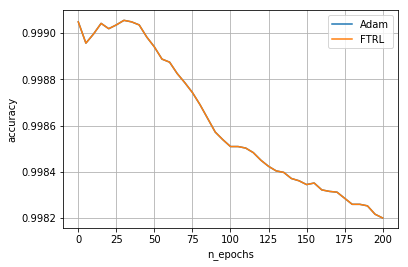

In [30]:
%pylab inline
for optim, title in [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
              (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=30, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='sparse',
        seed=42
    )
    n_epochs = 5
    anchor_epochs = range(0, 200+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs, show_progress=True)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend()
grid()

Populating the interactive namespace from numpy and matplotlib


/Users/weisihan/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
100%|██████████| 5/5 [00:10<00:00,  2.10s/epoch]
/Users/weisihan/Downloads/tffm-master/tffm/utils.py:195: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 5/5 [00:08<00:00,  1.61s/epoch]


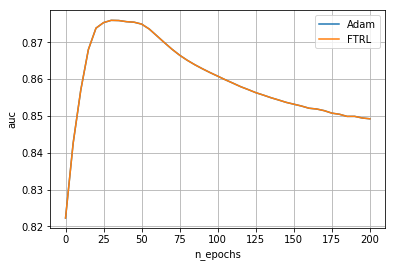

In [31]:


%pylab inline
for optim, title in [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
              (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=30, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='sparse',
        seed=42
    )
    n_epochs = 5
    anchor_epochs = range(0, 200+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs, show_progress=True)
        predictions = model.predict_proba(X_te_sparse)
        acc.append(roc_auc_score(y_te, predictions[:,1]))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('auc')
legend()
grid()